In [1]:
%matplotlib inline

# Parameter-shift rules

The output of a variational circuit (i.e., the expectation of an observable) can be written as a “quantum function” $f(\theta)$ parametrized by $\theta = \theta_1, \theta_2, \dots$. The partial derivative of $f(\theta)$ can in many cases be expressed as a linear combination of other quantum functions. Importantly, these other quantum functions typically use the same circuit, differing only in a shift of the argument. This means that partial derivatives of a variational circuit can be computed by using the same variational circuit architecture.

Recipes of how to get partial derivatives by evaluated parameter-shifted instances of a variational circuit are called parameter-shift rules, and have been first introduced to quantum machine learning in Mitarai et al. (2018), and extended in Schuld et al. (2018).

![](images/gradients2.png)





Making a rough analogy to classically computable functions, this is similar to how the derivative of the function $f(x)=\sin(x)$ is identical to $\frac{1}{2}\sin(x+\frac{\pi}{2}) - \frac{1}{2}\sin(x-\frac{\pi}{2})$. So the same underlying algorithm can be reused to compute both $\sin(x)$ and its derivative (by evaluating at $x\pm\frac{\pi}{2}$). This intuition holds for many quantum functions of interest: the same circuit can be used to compute both the quantum function and the gradient of the quantum function (This should be contrasted with software which can perform automatic differentiation on classical simulations of quantum circuits, such as Strawberry Fields).


## A more technical explanation

Quantum circuits are specified by a sequence of gates. The unitary transformation carried out by the circuit can thus be broken down into a product of unitaries:

$$
U(x; \theta) = U_N(\theta_{N}) U_{N-1}(\theta_{N-1}) \cdots U_i(\theta_i) \cdots U_1(\theta_1) U_0(x).
$$

Each of these gates is unitary, and therefore must have the form $U_{j}(\gamma_j)=\exp{(i\gamma_j H_j)}$ where $H_j$ is a Hermitian operator which generates the gate and $\gamma_j$ is the gate parameter. We have omitted which wire each unitary acts on, since it is not necessary for the following discussion.

Note:

In this example, we have used the input $x$ as the argument for gate $U_0$ and the parameters $\theta$ for the remaining gates. This is not required. Inputs and parameters can be arbitrarily assigned to different gates.


### A single parameterized gate

Let us single out a single parameter $\theta_i$ and its associated gate $U_i(\theta_i)$. For simplicity, we remove all gates except $U_i(\theta_i)$ and $U_0(x)$ for the moment. In this case, we have a simplified quantum circuit function

$$
f(x; \theta_i) = \langle 0 | U_0^\dagger(x)U_i^\dagger(\theta_i)\hat{B}U_i(\theta_i)U_0(x) | 0 \rangle = \langle x | U_i^\dagger(\theta_i)\hat{B}U_i(\theta_i) | x \rangle.
$$

For convenience, we rewrite the unitary conjugation as a linear transformation $\mathcal{M}_{\theta_i}$ acting on the operator $\hat{B}$:

$$
U_i^\dagger(\theta_i)\hat{B}U_i(\theta_i) = \mathcal{M}_{\theta_i}(\hat{B}).
$$

The transformation $\mathcal{M}_{\theta_i}$ depends smoothly on the parameter $\theta_i$, so this quantum function will have a well-defined gradient:

$$
\nabla_{\theta_i}f(x; \theta_i) = \langle x | \nabla_{\theta_i}\mathcal{M}_{\theta_i}(\hat{B}) | x \rangle \in \mathbb{R}.
$$

The key insight is that we can, in many cases of interest, express this gradient as a linear combination of the same transformation $\mathcal{M}$, but with different parameters. Namely,

$$
\nabla_{\theta_i}\mathcal{M}_{\theta_i}(\hat{B}) = c[\mathcal{M}_{\theta_i + s}(\hat{B}) - \mathcal{M}_{\theta_i - s}(\hat{B})],
$$

where the multiplier $c$ and the shift $s$ are determined completely by the type of transformation $\mathcal{M}$ and independent of the value of $\theta_i$.

Note

While this construction bears some resemblance to the numerical finite-difference method for computing derivatives, here $s$ is finite rather than infinitesimal.

### Multiple parameterized gates

To complete the story, we now go back to the case where there are many gates in the circuit. We can absorb any gates applied before gate i into the initial state: |\psi_{i-1}\rangle = U_{i-1}(\theta_{i-1}) \cdots U_{1}(\theta_{1})U_{0}(x)|0\rangle. Similarly, any gates applied after gate i are combined with the observable $\hat{B}: \hat{B}_{i+1} = U_{N}^\dagger(\theta_{N}) \cdots U_{i+1}^\dagger(\theta_{i+1}) \hat{B} U_{i+1}(\theta_{i+1}) \cdots U_{N}(\theta_{N})$.

With this simplification, the quantum circuit function becomes

$$
f(x; \theta) = \langle \psi_{i-1} | U_i^\dagger(\theta_i) \hat{B}_{i+1} U_i(\theta_i) | \psi_{i-1} \rangle = \langle \psi_{i-1} | \mathcal{M}_{\theta_i} (\hat{B}_{i+1}) | \psi_{i-1} \rangle,
$$

and its gradient is

$$
\nabla_{\theta_i}f(x; \theta) = \langle \psi_{i-1} | \nabla_{\theta_i}\mathcal{M}_{\theta_i} (\hat{B}_{i+1}) | \psi_{i-1} \rangle.
$$

This gradient has the exact same form as the single-gate case, except we modify the state $|x\rangle \rightarrow |\psi_{i-1}\rangle$ and the measurement operator $\hat{B}\rightarrow\hat{B}_{i+1}$. In terms of the circuit, this means we can leave all other gates as they are, and only modify gate $U(\theta_i)$ when we want to differentiate with respect to the parameter $\theta_i$.

Note

Sometimes we may want to use the same classical parameter with multiple gates in the circuit. Due to the product rule, the total gradient will then involve contributions from each gate that uses that parameter.


### Pauli gate example

Consider a quantum computer with parameterized gates of the form

$$
U_i(\theta_i)=\exp\left(-i\tfrac{\theta_i}{2}\hat{P}_i\right),
$$

where $\hat{P}_i=\hat{P}_i^\dagger$ is a Pauli operator.

The gradient of this unitary is

$$
\nabla_{\theta_i}U_i(\theta_i) = -\tfrac{i}{2}\hat{P}_i U_i(\theta_i) = -\tfrac{i}{2}U_i(\theta_i)\hat{P}_i .
$$

Substituting this into the quantum circuit function $f(x; \theta)$, we get

$$
\begin{align}
    \nabla_{\theta_i}f(x; \theta) = &
    \frac{i}{2}\langle \psi_{i-1} | U_i^\dagger(\theta_i) \left( P_i \hat{B}_{i+1} - \hat{B}_{i+1} P_i \right) U_i(\theta_i)| \psi_{i-1} \rangle \\
    = & \frac{i}{2}\langle \psi_{i-1} | U_i^\dagger(\theta_i) \left[P_i, \hat{B}_{i+1}\right]U_i(\theta_i) | \psi_{i-1} \rangle,
\end{align}
$$

where $[X,Y]=XY-YX$ is the commutator.

We now make use of the following mathematical identity for commutators involving Pauli operators (Mitarai et al. (2018)):

$$
\left[ \hat{P}_i, \hat{B} \right] = -i\left(U_i^\dagger\left(\tfrac{\pi}{2}\right)\hat{B}U_i\left(\tfrac{\pi}{2}\right) - U_i^\dagger\left(-\tfrac{\pi}{2}\right)\hat{B}U_i\left(-\tfrac{\pi}{2}\right) \right).
$$

Substituting this into the previous equation, we obtain the gradient expression

$$
\begin{align}
    \nabla_{\theta_i}f(x; \theta) = & \hphantom{-} \tfrac{1}{2} \langle \psi_{i-1} | U_i^\dagger\left(\theta_i + \tfrac{\pi}{2} \right) \hat{B}_{i+1} U_i\left(\theta_i + \tfrac{\pi}{2} \right) | \psi_{i-1} \rangle \\
    & - \tfrac{1}{2} \langle \psi_{i-1} | U_i^\dagger\left(\theta_i - \tfrac{\pi}{2} \right) \hat{B}_{i+1} U_i\left(\theta_i - \tfrac{\pi}{2} \right) | \psi_{i-1} \rangle.
\end{align}
$$

Finally, we can rewrite this in terms of quantum functions:

$$
\nabla_{\theta}f(x; \theta) = \tfrac{1}{2}\left[ f(x; \theta + \tfrac{\pi}{2}) - f(x; \theta - \tfrac{\pi}{2}) \right].
$$


### Gaussian gate example

For quantum devices with continuous-valued operators, such as photonic quantum computers, it is convenient to employ the Heisenberg picture, i.e., to track how the gates $U_i(\theta_i)$ transform the final measurement operator $\hat{B}$.

As an example, we consider the Squeezing gate. In the Heisenberg picture, the Squeezing gate causes the quadrature operators \hat{x} and \hat{p} to become rescaled:

$$
\begin{align}
    \mathcal{M}^S_r(\hat{x}) = & S^\dagger(r)\hat{x}S(r) \\
                                = & e^{-r}\hat{x}
\end{align}
$$

and

$$
\begin{align}
    \mathcal{M}^S_r(\hat{p}) = & S^\dagger(r)\hat{p}S(r) \\
                                = & e^{r}\hat{p}.
\end{align}
$$

Expressing this in matrix notation, we have

$$
\begin{align}
    \begin{bmatrix}
        \hat{x} \\
        \hat{p}
    \end{bmatrix}
    \rightarrow
    \begin{bmatrix}
       e^{-r} & 0 \\
       0      & e^r
    \end{bmatrix}
    \begin{bmatrix}
        \hat{x} \\
        \hat{p}
    \end{bmatrix}.
\end{align}
$$

The gradient of this transformation can easily be found:

$$
\begin{align}
    \nabla_r
    \begin{bmatrix}
        e^{-r} & 0 \\
        0 & e^r
    \end{bmatrix}
    =
    \begin{bmatrix}
        -e^{-r} & 0 \\
        0 & e^r
    \end{bmatrix}.
\end{align}
$$

We notice that this can be rewritten this as a linear combination of squeeze operations:

$$
\begin{align}
    \begin{bmatrix}
        -e^{-r} & 0 \\
        0 & e^r
    \end{bmatrix}
    =
    \frac{1}{2\sinh(s)}
    \left(
    \begin{bmatrix}
        e^{-(r+s)} & 0 \\
        0 & e^{r+s}
    \end{bmatrix}
    -
    \begin{bmatrix}
        e^{-(r-s)} & 0 \\
        0 & e^{r-s}
    \end{bmatrix}
    \right),
\end{align}
$$

where $s$ is an arbitrary nonzero shift (Note: In situations where no formula for automatic quantum gradients is known, one can fall back to approximate gradient estimation using numerical methods.
).

As before, assume that an input y has already been embedded into a quantum state $|y\rangle = U_0(y)|0\rangle$ before we apply the squeeze gate. If we measure the $\hat{x}$ operator, we will have the following quantum circuit function:

$$
f(y;r) = \langle y | \mathcal{M}^S_r (\hat{x}) | y \rangle.
$$

Finally, its gradient can be expressed as

$$
\begin{align}
    \nabla_r f(y;r) = &  \frac{1}{2\sinh(s)} \left[
                         \langle y | \mathcal{M}^S_{r+s} (\hat{x}) | y \rangle
                        -\langle y | \mathcal{M}^S_{r-s} (\hat{x}) | y \rangle \right] \\
                    = & \frac{1}{2\sinh(s)}\left[f(y; r+s) - f(y; r-s)\right].
\end{align}
$$

Note

For simplicity of the discussion, we have set the phase angle of the Squeezing gate to be zero. In the general case, Squeezing is a two-parameter gate, containing a squeezing magnitude and a squeezing angle. However, we can always decompose the two-parameter form into a Squeezing gate like the one above, followed by a Rotation gate.

In physical experiments, it is beneficial to choose s so that the additional squeezing is small. However, there is a tradeoff, because we also want to make sure $\frac{1}{2\sinh(s)}$ does not blow up numerically.


# Quantum gradients with backpropagation


Using backpropagation can speed up training of quantum circuits compared to the parameter-shift rule---if you are using a simulator.


In PennyLane, any quantum device, whether a hardware device or a
simulator, can be trained using the parameter shift rule to compute quantum gradients. Indeed, the parameter-shift
rule is ideally suited to hardware devices, as it does not require any knowledge about the internal workings of the device; it is sufficient to treat the device as a \'black box\', and to query it with different
input values in order to determine the gradient.

When working with simulators, however, we *do* have access to the internal (classical) computations being performed. This allows us to take advantage of other methods of computing the gradient, such as
backpropagation, which may be advantageous in certain regimes. In this tutorial, we will compare and contrast the parameter-shift rule against backpropagation, using the PennyLane
`default.qubit <pennylane.devices.default_qubit>` device.


## The parameter-shift rule example

The parameter-shift rule states that, given a variational quantum circuit $U(\boldsymbol \theta)$ composed of parametrized Pauli rotations, and some measured
observable $\hat{B}$, the derivative of the expectation value

$$\langle \hat{B} \rangle (\boldsymbol\theta) =
\langle 0 \vert U(\boldsymbol\theta)^\dagger \hat{B} U(\boldsymbol\theta) \vert 0\rangle$$

with respect to the input circuit parameters $\boldsymbol{\theta}$ is
given by

$$\nabla_{\theta_i}\langle \hat{B} \rangle(\boldsymbol\theta)
   =  \frac{1}{2}
         \left[
             \langle \hat{B} \rangle\left(\boldsymbol\theta + \frac{\pi}{2}\hat{\mathbf{e}}_i\right)
           - \langle \hat{B} \rangle\left(\boldsymbol\theta - \frac{\pi}{2}\hat{\mathbf{e}}_i\right)
         \right].$$

Thus, the gradient of the expectation value can be calculated by
evaluating the same variational quantum circuit, but with shifted
parameter values (hence the name, parameter-shift rule!).

Let\'s have a go implementing the parameter-shift rule manually in
PennyLane.


In [3]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

# set the random seed
np.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

Let\'s test the variational circuit evaluation with some parameter
input:


In [4]:
# initial parameters
params = np.random.random([6], requires_grad=True)

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871566


We can also draw the executed quantum circuit:


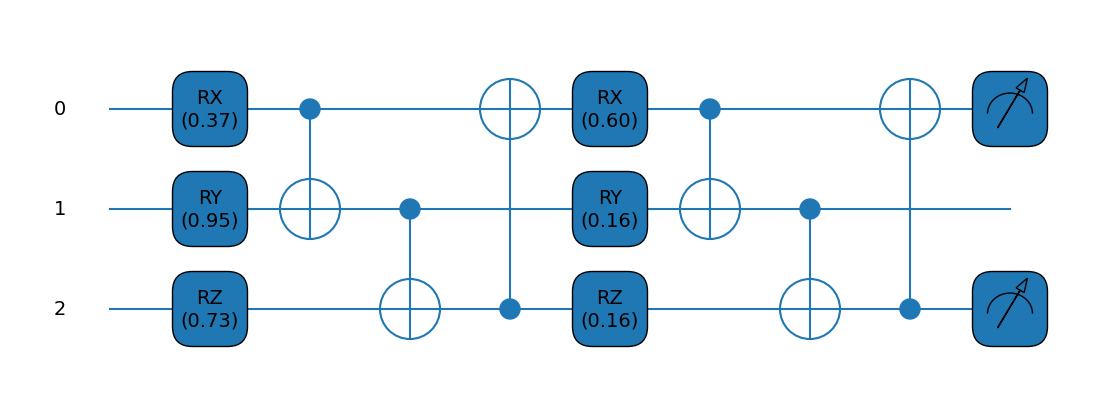

In [5]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

Now that we have defined our variational circuit QNode, we can construct
a function that computes the gradient of the $i\text{th}$ parameter
using the parameter-shift rule.


In [6]:
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))

-0.06518877224958124


In order to compute the gradient with respect to *all* parameters, we
need to loop over the index `i`:


In [7]:
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  4.16333634e-17]


We can compare this to PennyLane\'s *built-in* quantum gradient support
by using the `qml.grad <pennylane.grad>`
function, which allows us to compute gradients of hybrid
quantum-classical cost functions. Remember, when we defined the QNode,
we specified that we wanted it to be differentiable using the
parameter-shift method (`diff_method="parameter-shift"`).


In [8]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

-0.06518877224958125


Alternatively, we can directly compute quantum gradients of QNodes using
PennyLane\'s built in
`qml.gradients <pennylane.gradients>`
module:


In [9]:
print(qml.gradients.param_shift(circuit)(params))

[-6.51887722e-02 -2.72891905e-02 -2.77555756e-17 -9.33934621e-02
 -7.61067572e-01  4.16333634e-17]


If you count the number of quantum evaluations, you will notice that we
had to evaluate the circuit `2*len(params)` number of times in order to
compute the quantum gradient with respect to all parameters. While
reasonably fast for a small number of parameters, as the number of
parameters in our quantum circuit grows, so does both

1.  the circuit depth (and thus the time taken to evaluate each
    expectation value or \'forward\' pass), and
2.  the number of parameter-shift evaluations required.

Both of these factors increase the time taken to compute the gradient
with respect to all parameters.

### Benchmarking

Let\'s consider an example with a significantly larger number of
parameters. We\'ll make use of the
`~pennylane.StronglyEntanglingLayers`
template to make a more complicated QNode.


In [10]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(params.size)
print(circuit(params))

180
0.8947771876917631


This circuit has 180 parameters. Let\'s see how long it takes to perform
a forward pass of the circuit.


In [11]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.01652761589939473 sec per loop


We can now estimate the time taken to compute the full gradient vector,
and see how this compares.


In [12]:
# create the gradient function
grad_fn = qml.grad(circuit)

times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 6.592562994100445 sec per loop


Based on the parameter-shift rule, we expect that the amount of time to compute the quantum gradients should be approximately $2p\Delta t_{f}$ where $p$ is the number of parameters and $\Delta t_{f}$ if the time
taken for the forward pass. Let\'s verify this:


In [13]:
print(2 * forward_time * params.size)

5.9499417237821035


## Backpropagation example


An alternative to the parameter-shift rule for computing gradients is [reverse-mode
autodifferentiation](https://en.wikipedia.org/wiki/Reverse_accumulation). Unlike the parameter-shift method, which requires $2p$ circuit evaluations for $p$ parameters, reverse-mode requires only a *single* forward pass of the differentiable function to compute the gradient of all variables, at the expense of increased memory usage. During the forward pass, the results of all intermediate subexpressions are stored; the computation is then traversed *in reverse*, with the gradient computed by repeatedly applying the chain rule. In most classical machine learning settings (where we are training scalar loss functions consisting of a large number of parameters), reverse-mode
autodifferentiation is the preferred method of autodifferentiation\-\--the reduction in computational time enables larger and more complex models to be successfully trained. The
backpropagation algorithm is a particular special-case of reverse-mode autodifferentiation, which has helped lead to the machine learning explosion we see today.

In quantum machine learning, however, the inability to store and utilize the results of *intermediate* quantum operations on hardware remains a barrier to using backprop; while reverse-mode autodifferentiation works
fine for small quantum simulations, only the parameter-shift rule can be used to compute gradients on quantum hardware directly. Nevertheless, when training quantum models via classical simulation, it\'s useful to
explore the regimes where reverse-mode differentiation may be a better choice than the parameter-shift rule.

### Benchmarking


When creating a QNode, `PennyLane supports various methods of differentiation
<code/api/pennylane.qnode>`, including `"parameter-shift"` (which we used previously), `"finite-diff"`, `"reversible"`, and `"backprop"`. While `"parameter-shift"` works with all devices (simulator or hardware), `"backprop"` will only work for specific simulator devices that are designed to support backpropagation.

One such device is `default.qubit <pennylane.devices.DefaultQubit>`. It has backends written using TensorFlow, JAX, and
Autograd, so when used with the TensorFlow, JAX, and Autograd interfaces respectively, supports backpropagation. In this demo, we will use the default Autograd interface.


In [ ]:
dev = qml.device("default.qubit", wires=4)

When defining the QNode, we specify `diff_method="backprop"` to ensure that we are using backpropagation mode. Note that this is the *default differentiation mode* for the `default.qubit` device.


In [ ]:
@qml.qnode(dev, diff_method="backprop")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(circuit(params))

Let\'s see how long it takes to perform a forward pass of the circuit.


In [ ]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Comparing this to the forward pass from `default.qubit`, we note that there is some potential overhead from using backpropagation. We can now time how long it takes to perform a gradient computation via
backpropagation:


In [ ]:
times = timeit.repeat("qml.grad(circuit)(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

Unlike with the parameter-shift rule, the time taken to perform the backwards pass appears of the order of a single forward pass! The can significantly speed up training of simulated circuits with many
parameters.

## Send it after class: Time comparison


Let\'s compare the two differentiation approaches as the number of trainable parameters in the variational circuit increases, by timing both the forward pass and the gradient computation as the number of
layers is allowed to increase.


In [ ]:
dev = qml.device("default.qubit", wires=4)

def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

We\'ll continue to use the same ansatz as before, but to reduce the time taken to collect the data, we\'ll reduce the number and repetitions of timings per data point. Below, we loop over a variational circuit depth ranging from 0 (no gates/ trainable parameters) to 20. Each layer will contain $3N$ parameters, where $N$ is the number of wires (in this case, we have $N=4$).


In [ ]:
reps = #fill me
num = #fill me

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, -fill me-):
    param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=depth)
    params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
    num_params = params.size

    # forward pass timing
    # ===================

    qnode_shift = #fill me
    qnode_backprop = #fill me

    # parameter-shift
    t = timeit.repeat("qnode_shift(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qnode_backprop(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============

    qnode_shift = #fill me
    qnode_backprop = #fill me

    # parameter-shift
    t = timeit.repeat("qml.grad(qnode_shift)(params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qml.grad(qnode_backprop)(params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

We now import matplotlib, and plot the results.


In [ ]:
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()

We can see that the computational time for the parameter-shift rule increases with increasing number of parameters, as expected, whereas the computational time for backpropagation appears much more constant, with
perhaps a minute linear increase with $p$. Note that the plots are not perfectly linear, with some \'bumpiness\' or noisiness. This is likely due to low-level operating system jitter, and other environmental
fluctuations\-\--increasing the number of repeats can help smooth out the plot.

For a better comparison, we can scale the time required for computing the quantum gradients against the time taken for the corresponding forward pass:


In [ ]:
gradient_shift[1] /= forward_shift[1, 1:]
gradient_backprop[1] /= forward_backprop[1, 1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")

# perform a least squares regression to determine the linear best fit/gradient
# for the normalized time vs. number of parameters
x = gradient_shift[0]
m_shift, c_shift = np.polyfit(*gradient_shift, deg=1)
m_back, c_back = np.polyfit(*gradient_backprop, deg=1)

ax.plot(x, m_shift * x + c_shift, '--', label=f"{m_shift:.2f}p{c_shift:+.2f}")
ax.plot(x, m_back * x + c_back, '--', label=f"{m_back:.2f}p{c_back:+.2f}")

ax.set_ylabel("Normalized time")
ax.set_xlabel("Number of parameters")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()

We can now see clearly that there is constant overhead for backpropagation with `default.qubit`, but the parameter-shift rule scales as $\sim 2p$.